In [87]:
import cv2
import os
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from ast import literal_eval

## Redimension de Imagenes +  Escalado de Pixeles

In [5]:
root_imagenes = 'imagenes/furgones'
root_imagenes_mnist = 'imagenes/furgones_mnist/'

In [14]:
def preprocesar_imagen(ruta_imagen):
    for path, subdirs, files in os.walk(ruta_imagen):
        name = ""
        for name in files:
            try:
                img_path = os.path.join(path,name)
                img = cv2.imread(img_path)
                img = resize_image(root_autos_mnist + name,img)
                flip_image(root_autos_mnist + "_flip_" + name,img)
                
                
            except Exception as e:
                print(e)
                print(name)

In [15]:
preprocesar_imagen(root_imagenes)

In [6]:
def resize_image(path,img):
    resize_img=cv2.resize(img, (28,28))
    cv2.imwrite(path,resize_img)  
    return resize_img
    

In [7]:
def flip_image(path,img):
    flip_img=cv2.flip(img,1)
    cv2.imwrite(path,flip_img)  

In [32]:
rutas_images_mnist = [
    'imagenes/autos_mnist/',
    'imagenes/camionetas_mnist/',
    'imagenes/furgones_mnist/',
    'imagenes/motos_mnist/'
]

In [49]:
# Para cada categoria, hacemos el siguiente procedimiento: X=imagen, y=numero de categoria.
labels = ['Autoelevador', 'Auto', 'Buggy', 'Camioneta', 'Camion', 'Colectivo',
         'Cuatriciclo', 'Furgon', 'Moto', 'Pala Cargadora']

In [50]:
def crear_dataframe():
    arreglo = []
    df = pd.DataFrame()
    for ruta_imagen in rutas_images_mnist:
        print(ruta_imagen)
        for path, subdirs, files in os.walk(ruta_imagen):
            name = ""
            for name in files:
                try:
                    # Abro la imagen
                    img_path = os.path.join(path,name)
                    img = cv2.imread(img_path)
                    
                    # PASO A ESCALA DE GRISES --> este me deja una sola dimension de RGB
                    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
                    
                    # Normalización DE PIXELES, DIVIDO CADA PIXEL POR 255,
                    img = img / 255 

                    # aca me quedo con un solo canal del RGB
                    array_img = img.ravel() 
                    
                    numero_categoria = get_numero_categoria(ruta_imagen)
                    
                    array_img = np.insert(array_img,len(array_img), numero_categoria)
                    arreglo.append(array_img) 
                    
                except Exception as e:
                    print(e)
                    #print(name)


        df = pd.DataFrame(arreglo)
        #print(df)
    return df
# Duda:en ningun momento del for vacio el arreglo[]
# No serian solamente dos columnas.

In [48]:
def get_numero_categoria(categoria):
    if("elevador" in categoria):
        return 0
    elif("auto" in categoria):
        return 1
    elif("camioneta" in categoria):
        return 2
    elif("camion" in categoria):
        return 3
    elif("colectivo" in categoria):
        return 4
    elif("cuatriciclo" in categoria):
        return 5
    elif("furgon" in categoria):
        return 6
    elif("moto" in categoria):
        return 7
    elif("pala" in categoria):
        return 8
    else:
        return 0

In [51]:
df = crear_dataframe()

imagenes/autos_mnist/
imagenes/camionetas_mnist/
imagenes/furgones_mnist/
imagenes/motos_mnist/


In [52]:
print(df)

           0         1         2         3         4         5         6    \
0     0.721569  0.733333  0.686275  0.670588  0.686275  0.631373  0.670588   
1     0.650980  0.627451  0.647059  0.643137  0.650980  0.650980  0.733333   
2     0.294118  0.674510  0.631373  0.603922  0.580392  0.521569  0.564706   
3     0.462745  0.596078  0.545098  0.505882  0.498039  0.466667  0.529412   
4     0.392157  0.388235  0.364706  0.352941  0.254902  0.282353  0.337255   
5     0.639216  0.541176  0.572549  0.654902  0.450980  0.576471  0.556863   
6     0.752941  0.780392  0.874510  0.882353  0.854902  0.847059  0.533333   
7     0.317647  0.309804  0.301961  0.321569  0.329412  0.572549  0.219608   
8     0.372549  0.325490  0.364706  0.156863  0.356863  0.454902  0.294118   
9     0.486275  0.784314  0.862745  0.831373  0.725490  0.827451  0.839216   
10    0.564706  0.741176  0.529412  0.725490  0.666667  0.827451  0.611765   
11    0.741176  0.756863  0.756863  0.772549  0.788235  0.796078

In [58]:
# https://chrisalbon.com/python/data_wrangling/pandas_saving_dataframe_as_csv/
# Guardamos el dataframe
df.to_csv('data_frame_imagenes', sep=',')

In [60]:
# Abrimos el dataframe con las imagenes procesadas
df = pd.read_csv('data_frame_imagenes', sep=',')

In [61]:
df

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,775,776,777,778,779,780,781,782,783,784
0,0,0.721569,0.733333,0.686275,0.670588,0.686275,0.631373,0.670588,0.682353,0.725490,...,0.439216,0.407843,0.415686,0.427451,0.431373,0.419608,0.415686,0.419608,0.490196,1.0
1,1,0.650980,0.627451,0.647059,0.643137,0.650980,0.650980,0.733333,0.682353,0.674510,...,0.274510,0.341176,0.352941,0.427451,0.501961,0.529412,0.545098,0.545098,0.568627,1.0
2,2,0.294118,0.674510,0.631373,0.603922,0.580392,0.521569,0.564706,0.568627,0.694118,...,0.047059,0.054902,0.058824,0.082353,0.121569,0.145098,0.160784,0.192157,0.207843,1.0
3,3,0.462745,0.596078,0.545098,0.505882,0.498039,0.466667,0.529412,0.529412,0.505882,...,0.078431,0.074510,0.078431,0.078431,0.113725,0.435294,0.474510,0.717647,0.729412,1.0
4,4,0.392157,0.388235,0.364706,0.352941,0.254902,0.282353,0.337255,0.870588,0.956863,...,0.050980,0.047059,0.043137,0.054902,0.105882,0.094118,0.086275,0.070588,0.086275,1.0
5,5,0.639216,0.541176,0.572549,0.654902,0.450980,0.576471,0.556863,0.960784,0.968627,...,0.709804,0.768627,0.780392,0.792157,0.827451,0.847059,0.866667,0.866667,0.886275,1.0
6,6,0.752941,0.780392,0.874510,0.882353,0.854902,0.847059,0.533333,0.541176,0.682353,...,0.850980,0.850980,0.858824,0.850980,0.862745,0.831373,0.819608,0.776471,0.815686,1.0
7,7,0.317647,0.309804,0.301961,0.321569,0.329412,0.572549,0.219608,0.070588,0.886275,...,0.380392,0.450980,0.494118,0.584314,0.592157,0.560784,0.521569,0.552941,0.556863,1.0
8,8,0.372549,0.325490,0.364706,0.156863,0.356863,0.454902,0.294118,0.101961,0.886275,...,0.674510,0.686275,0.654902,0.627451,0.674510,0.674510,0.678431,0.713725,0.741176,1.0
9,9,0.486275,0.784314,0.862745,0.831373,0.725490,0.827451,0.839216,0.423529,0.403922,...,0.698039,0.733333,0.717647,0.709804,0.713725,0.713725,0.749020,0.713725,0.694118,1.0


In [78]:
df_datos = df
X = df_datos[df_datos.columns[:-1]].values
y = df_datos[df_datos.columns[len(df_datos.columns)-1]].values

In [81]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    shuffle=True,
    random_state=42, 
)

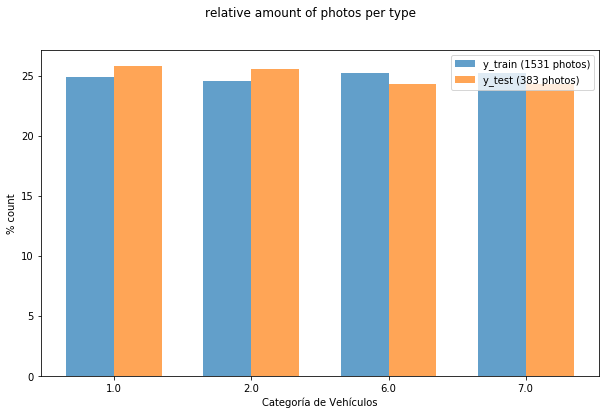

In [115]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5

    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]

    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'

    xtemp = np.arange(len(unique))
    
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('Categoría de Vehículos')
    plt.ylabel(ylabel_text)

plt.figure(figsize=(10,6)) 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
legend1 = plt.legend([
    'y_train ({0} photos)'.format(len(y_train)),
    'y_test ({0} photos)'.format(len(y_test))
])
#legend2 = plt.legend([
 #   '1 = auto',
  #  '8 = moto'
#],loc=1)
#plt.gca().add_artist(legend1)
#plt.gca().add_artist(legend2)

In [84]:
componentes = PCA(n_components = 2).fit_transform(X_train)

In [92]:
plt.rcParams["figure.figsize"] = [21, 18]

In [93]:
class_names = np.unique(y_test)
class_names

array([1., 2., 6., 7.])

In [99]:
labels = ['Auto', 'Camioneta', 'Furgon', 'Moto']

colors = ['rgb(0,31,63)', 'rgb(255,133,27)', 'rgb(255,65,54)', 'rgb(0,116,217)', 'rgb(133,20,75)', 'rgb(57,204,204)',
'rgb(240,18,190)', 'rgb(46,204,64)', 'rgb(1,255,112)', 'rgb(255,220,0)',
'rgb(76,114,176)', 'rgb(85,168,104)', 'rgb(129,114,178)', 'rgb(100,181,205)']

In [100]:
for k, i in enumerate(class_names):
    print(k,i)

0 1.0
1 2.0
2 6.0
3 7.0


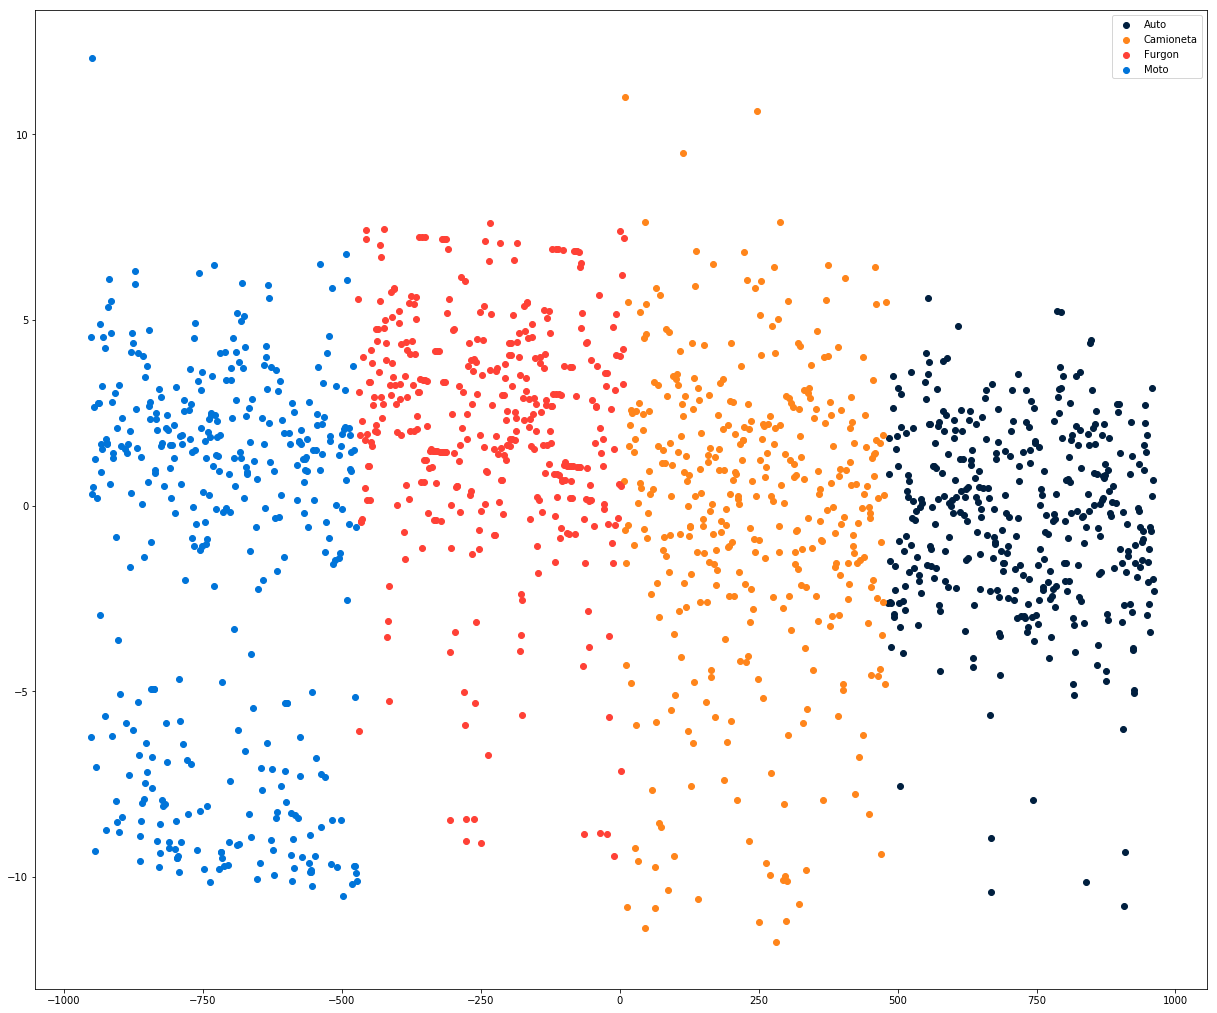

In [102]:
for k, i in enumerate(class_names):
    plt.scatter(componentes[y_train == i, 0],
               componentes[y_train == i, 1],
               color = '#%02x%02x%02x' % literal_eval(colors[k][3:]),label = labels[k])
plt.legend()
plt.show()